In [1]:
import numpy as np
import pandas as pd
import pickle
import scipy.sparse as sp
from scipy.sparse.linalg import svds

In [2]:
ratings = pd.read_csv('ratings.csv')

In [3]:
len(ratings)

10000054

In [4]:
ratings = ratings[['userId', 'movieId','rating']]

In [5]:
ratings_df = ratings.groupby(['userId','movieId']).aggregate(np.max)

In [6]:
len(ratings_df)

10000054

In [7]:
ratings.head()

,userId,movieId,rating
0,1,122,5.0
1,1,185,5.0
2,1,231,5.0
3,1,292,5.0
4,1,316,5.0


In [8]:
ratings_df.head()

rating
userId movieId        
1      122         5.0
       185         5.0
       231         5.0
       292         5.0
       316         5.0

In [9]:
len(ratings['userId'].unique())

69878

In [10]:
#Getting the percentage count of each rating value 
count_ratings = ratings.groupby('rating').count()
count_ratings['perc_total']=round(count_ratings['userId']*100/count_ratings['userId'].sum(),1)

In [11]:
count_ratings

,userId,movieId,perc_total
rating,,,
0.5,94988,94988,0.9
1.0,384180,384180,3.8
1.5,118278,118278,1.2
2.0,790306,790306,7.9
2.5,370178,370178,3.7
3.0,2356676,2356676,23.6
3.5,879764,879764,8.8
4.0,2875850,2875850,28.8
4.5,585022,585022,5.9


<AxesSubplot:xlabel='rating'>

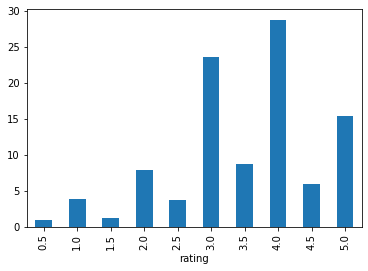

In [12]:
#Visualising the percentage total for each rating
count_ratings['perc_total'].plot.bar()

In [13]:
movie_list = pd.read_csv('movies.csv')

In [14]:
len(movie_list)

10681

In [15]:
movie_list.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [16]:
tags = pd.read_csv('tags.csv')

In [17]:
tags.head()

,userId,movieId,tag,timestamp
0,15,4973,excellent!,1215184630
1,20,1747,politics,1188263867
2,20,1747,satire,1188263867
3,20,2424,chick flick 212,1188263835
4,20,2424,hanks,1188263835


In [18]:
genres = movie_list['genres']

In [19]:
genres.head()

0    Adventure|Animation|Children|Comedy|Fantasy
1                     Adventure|Children|Fantasy
2                                 Comedy|Romance
3                           Comedy|Drama|Romance
4                                         Comedy
Name: genres, dtype: object

In [20]:
#Tách các thể loại trong cột geners 
genre_list = ""
for index,row in movie_list.iterrows():
        genre_list += row.genres + "|"
genre_list_split = genre_list.split('|')
new_list = list(set(genre_list_split))
new_list.remove('')
new_list

['IMAX',
 'Romance',
 'Comedy',
 'Children',
 'Animation',
 'Drama',
 'Film-Noir',
 'Fantasy',
 '(no genres listed)',
 'Musical',
 'War',
 'Horror',
 'Adventure',
 'Western',
 'Thriller',
 'Crime',
 'Mystery',
 'Action',
 'Sci-Fi',
 'Documentary']

In [21]:
#Thêm các cột thể loại với giá trị 0,1 tương ứng với thể loại phim
movies_with_genres = movie_list.copy()

for genre in new_list :
    movies_with_genres[genre] = movies_with_genres.apply(lambda _:int(genre in _.genres), axis = 1)

In [22]:
#Calculating the sparsity
no_of_users = len(ratings['userId'].unique())
no_of_movies = len(ratings['movieId'].unique())

sparsity = round(1.0 - len(ratings)/(1.0*(no_of_movies*no_of_users)),3)
print(sparsity)

0.987


In [23]:
# Counting the number of unique movies in the dataset.
len(ratings['movieId'].unique())

10677

In [24]:
# Tính xếp hạng trung bình và số đánh giá cho mỗi phim
avg_movie_rating = pd.DataFrame(ratings.groupby('movieId')['rating'].agg(['mean','count']))

In [25]:
avg_movie_rating.head()

,mean,count
movieId,,
1,3.928769,26449
2,3.208070,12032
3,3.150385,7790
4,2.860544,1764
5,3.077435,7135


In [26]:
len(avg_movie_rating)

10677

In [27]:
#calculate the percentile count. It gives the no of ratings at least 70% of the movies have
np.percentile(avg_movie_rating['count'],70)

444.0

In [28]:
#Get the average movie rating across all movies 
avg_rating_all=ratings['rating'].mean()
avg_rating_all
#set a minimum threshold for number of reviews that the movie has to have
min_reviews=22
min_reviews
movie_score = avg_movie_rating.loc[avg_movie_rating['count']>min_reviews]
movie_score.head()

,mean,count
movieId,,
1,3.928769,26449
2,3.208070,12032
3,3.150385,7790
4,2.860544,1764
5,3.077435,7135


In [29]:
len(movie_score)

8771

In [30]:
#Tạo một hàm cho điểm xếp hạng có trọng số dựa trên số lượng bài đánh giá
def weighted_rating(x, m=min_reviews, C=avg_rating_all):
    v = x['count']
    R = x['mean']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [31]:
#Tính điểm trọng số (weighted score) cho mỗi phim
movie_score['weighted_score'] = movie_score.apply(weighted_rating, axis=1)
movie_score.head()

<ipython-input-31-5b6e2ffd27fd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_score['weighted_score'] = movie_score.apply(weighted_rating, axis=1)


,mean,count,weighted_score
movieId,,,
1,3.928769,26449,3.928423
2,3.208070,12032,3.208626
3,3.150385,7790,3.151405
4,2.860544,1764,2.868574
5,3.077435,7135,3.078772


In [32]:
#join movie details to movie ratings
movies_with_genres.index.name = None#.drop(columns=[])#, axis = 1)
movies_with_genres = movies_with_genres.rename_axis(None) 
movie_score = pd.merge(movie_score,movies_with_genres,on='movieId')
movie_score.head()

,movieId,mean,count,weighted_score,title,genres,IMAX,Romance,Comedy,Children,...,War,Horror,Adventure,Western,Thriller,Crime,Mystery,Action,Sci-Fi,Documentary
0,1,3.928769,26449,3.928423,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,...,0,0,1,0,0,0,0,0,0,0
1,2,3.208070,12032,3.208626,Jumanji (1995),Adventure|Children|Fantasy,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
2,3,3.150385,7790,3.151405,Grumpier Old Men (1995),Comedy|Romance,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,4,2.860544,1764,2.868574,Waiting to Exhale (1995),Comedy|Drama|Romance,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,3.077435,7135,3.078772,Father of the Bride Part II (1995),Comedy,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
#Danh sách các phim đạt điểm cao nhất trong toàn bộ các phim
pd.DataFrame(movie_score.sort_values(['weighted_score'],ascending=False)[['title','count','mean','weighted_score','genres']][:20])

,title,count,mean,weighted_score,genres
308,"Shawshank Redemption, The (1994)",31126,4.457238,4.456571,Drama
794,"Godfather, The (1972)",19814,4.415085,4.414084,Crime|Drama
49,"Usual Suspects, The (1995)",24037,4.367142,4.366361,Crime|Mystery|Thriller
510,Schindler's List (1993),25777,4.363483,4.362757,Drama|War
842,Casablanca (1942),12507,4.319741,4.318323,Drama|Romance
852,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),3255,4.321966,4.316531,Drama|Film-Noir|Romance
834,Rear Window (1954),8825,4.316544,4.314544,Mystery|Thriller
1817,Seven Samurai (Shichinin no samurai) (1954),5751,4.314119,4.311064,Action|Drama
1117,"Third Man, The (1949)",3265,4.313629,4.308267,Film-Noir|Mystery|Thriller
3126,Double Indemnity (1944),2403,4.315439,4.308154,Crime|Drama|Film-Noir


In [34]:
# Cung cấp những bộ phim hay nhất theo thể loại dựa weighted score được tính bằng công thức IMDB
def best_movies_by_genre(genre,top_n):
    return pd.DataFrame(movie_score.loc[(movie_score[genre]==1)].sort_values(['weighted_score'],ascending=False)[['title','count','mean','weighted_score']][:top_n])

In [35]:
#Funcion trả về top phim xếp hạng cao nhất theo thể loại
best_movies_by_genre('Action',10)  

,title,count,mean,weighted_score
1817,Seven Samurai (Shichinin no samurai) (1954),5751,4.314119,4.311064
8619,"Dark Knight, The (2008)",2598,4.294842,4.288272
2776,Yojimbo (1961),1693,4.277614,4.267798
1104,Raiders of the Lost Ark (Indiana Jones and the...,21803,4.261317,4.260562
5426,City of God (Cidade de Deus) (2002),4370,4.261899,4.258145
250,Star Wars Episode IV - A New Hope (a.k.a. Star...,28566,4.220209,4.219665
2344,"Matrix, The (1999)",23229,4.205132,4.204476
1102,Star Wars Episode V - The Empire Strikes Back ...,23091,4.194361,4.193712
1103,"Princess Bride, The (1987)",16520,4.194159,4.193252
2708,Fight Club (1999),16334,4.190033,4.189122


In [36]:
best_movies_by_genre('Drama',10)  

,title,count,mean,weighted_score
308,"Shawshank Redemption, The (1994)",31126,4.457238,4.456571
794,"Godfather, The (1972)",19814,4.415085,4.414084
510,Schindler's List (1993),25777,4.363483,4.362757
842,Casablanca (1942),12507,4.319741,4.318323
852,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),3255,4.321966,4.316531
1817,Seven Samurai (Shichinin no samurai) (1954),5751,4.314119,4.311064
3126,Double Indemnity (1944),2403,4.315439,4.308154
1126,"Godfather Part II, The (1974)",13281,4.303215,4.301907
1086,Paths of Glory (1957),1778,4.306805,4.297096
1100,One Flew Over the Cuckoo's Nest (1975),14435,4.292380,4.291193


In [37]:
best_movies_by_genre('Horror',10)  

,title,count,mean,weighted_score
569,"Silence of the Lambs, The (1991)",33668,4.204200,4.203748
1124,Psycho (1960),10384,4.093991,4.092761
1119,Alien (1979),15843,4.037903,4.037174
46,Seven (a.k.a. Se7en) (1995),22521,4.031238,4.030731
1181,Young Frankenstein (1974),8297,4.020309,4.018965
1106,Aliens (1986),14167,4.004765,4.004001
1161,"Shining, The (1980)",11423,4.003896,4.002951
6301,Diabolique (Les Diaboliques) (1955),426,4.012911,3.988333
5913,Wait Until Dark (1967),536,3.999067,3.979880
8712,Let the Right One In (LǾt den r��tte komma in)...,95,4.068421,3.963874


In [38]:
best_movies_by_genre('Comedy',10)  

,title,count,mean,weighted_score
698,Dr. Strangelove or How I Learned to Stop Worry...,11774,4.298072,4.296607
1100,One Flew Over the Cuckoo's Nest (1975),14435,4.292380,4.291193
1061,Wallace & Gromit The Wrong Trousers (1993),7932,4.275908,4.273796
693,Wallace & Gromit A Close Shave (1995),6332,4.274953,4.272312
2776,Yojimbo (1961),1693,4.277614,4.267798
4549,"Amelie (Fabuleux destin d'AmǸlie Poulain, Le) ...",9681,4.246875,4.245210
2769,"General, The (1927)",1112,4.257644,4.243186
673,Wallace & Gromit The Best of Aardman Animation...,4356,4.229798,4.226193
880,"Thin Man, The (1934)",1857,4.222671,4.214355
881,His Girl Friday (1940),2084,4.215211,4.207870


In [39]:
ratings_movies = pd.merge(ratings,movie_list, on = 'movieId')

In [40]:
ratings_movies.head(10)

,userId,movieId,rating,title,genres
0,1,122,5.0,Boomerang (1992),Comedy|Romance
1,139,122,3.0,Boomerang (1992),Comedy|Romance
2,149,122,2.5,Boomerang (1992),Comedy|Romance
3,182,122,3.0,Boomerang (1992),Comedy|Romance
4,215,122,4.5,Boomerang (1992),Comedy|Romance
5,217,122,3.0,Boomerang (1992),Comedy|Romance
6,281,122,3.0,Boomerang (1992),Comedy|Romance
7,326,122,3.0,Boomerang (1992),Comedy|Romance
8,351,122,1.0,Boomerang (1992),Comedy|Romance
9,357,122,3.0,Boomerang (1992),Comedy|Romance


In [41]:
ratings_movies

,userId,movieId,rating,title,genres
0,1,122,5.0,Boomerang (1992),Comedy|Romance
1,139,122,3.0,Boomerang (1992),Comedy|Romance
2,149,122,2.5,Boomerang (1992),Comedy|Romance
3,182,122,3.0,Boomerang (1992),Comedy|Romance
4,215,122,4.5,Boomerang (1992),Comedy|Romance
...,...,...,...,...,...
10000049,67385,63481,3.5,Soul Men (2008),Comedy|Musical
10000050,67542,63481,3.0,Soul Men (2008),Comedy|Musical
10000051,67385,64652,2.0,Delgo (2008),Adventure|Animation|Comedy|Fantasy|Romance
10000052,69135,64427,4.0,Much Ado About Something (2001),Documentary


In [42]:
#Gets the other top 10 movies which are watched by the people who saw this particular movie
def get_other_movies(movie_name):
    #get all users who watched a specific movie
    df_movie_users_series = ratings_movies.loc[ratings_movies['title']==movie_name]['userId']
    #convert to a data frame
    df_movie_users = pd.DataFrame(df_movie_users_series,columns=['userId'])
    #get a list of all other movies watched by these users
    other_movies = pd.merge(df_movie_users,ratings_movies,on='userId')
    #get a list of the most commonly watched movies by these other user
    other_users_watched = pd.DataFrame(other_movies.groupby('title')['userId'].count()).sort_values('userId',ascending=False)
    other_users_watched['perc_who_watched'] = round(other_users_watched['userId']*100/other_users_watched['userId'][0],1)
    return other_users_watched[:10]

In [43]:
#Lấy ra 10 bộ phim hàng đầu khác từ những người đã xem 'Iron Man (2008)' 
get_other_movies('Iron Man (2008)')

,userId,perc_who_watched
title,,
Iron Man (2008),2013,100.0
"Matrix, The (1999)",1752,87.0
"Lord of the Rings The Fellowship of the Ring, The (2001)",1648,81.9
Fight Club (1999),1595,79.2
Forrest Gump (1994),1578,78.4
Pulp Fiction (1994),1567,77.8
"Lord of the Rings The Two Towers, The (2002)",1559,77.4
"Lord of the Rings The Return of the King, The (2003)",1555,77.2
"Shawshank Redemption, The (1994)",1525,75.8


In [44]:
avg_movie_rating.head()

,mean,count
movieId,,
1,3.928769,26449
2,3.208070,12032
3,3.150385,7790
4,2.860544,1764
5,3.077435,7135


In [45]:
#Các phim có hơn 10 lượt xếp hạng
movie_plus_10_ratings = avg_movie_rating.loc[avg_movie_rating['count']>=10]
print(len(movie_plus_10_ratings))

9708


In [46]:
movie_plus_10_ratings

,mean,count
movieId,,
1,3.928769,26449
2,3.208070,12032
3,3.150385,7790
4,2.860544,1764
5,3.077435,7135
...,...,...
64839,4.107143,28
64957,3.820000,75
64969,3.425926,27


In [47]:
filtered_ratings = pd.merge(movie_plus_10_ratings, ratings, on="movieId")
len(filtered_ratings)

9995471

In [48]:
filtered_ratings.head()

,movieId,mean,count,userId,rating
0,1,3.928769,26449,5,1.0
1,1,3.928769,26449,14,3.0
2,1,3.928769,26449,18,3.0
3,1,3.928769,26449,23,5.0
4,1,3.928769,26449,24,5.0


In [49]:
#create a matrix table with movieIds on the rows and userIds in the columns.
#replace NAN values with 0
movie_wide = filtered_ratings.pivot(index = 'movieId', columns = 'userId', values = 'rating').fillna(0)
movie_wide.head()

userId,1,2,3,4,5,6,7,8,9,10,...,71558,71559,71560,71561,71562,71563,71564,71565,71566,71567
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,5.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,...,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
from sklearn.neighbors import NearestNeighbors
#specify model parameters
model_knn = NearestNeighbors(metric='cosine',algorithm='brute')
#fit model to the data set
model_knn.fit(movie_wide)

NearestNeighbors(algorithm='brute', metric='cosine')

In [51]:
#Gets the top 10 nearest neighbours got the movie
def print_similar_movies(query_index) :
    #get the list of user ratings for a specific userId
    query_index_movie_ratings = movie_wide.loc[query_index,:].values.reshape(1,-1)
    #get the closest 10 movies and their distances from the movie specified
    distances,indices = model_knn.kneighbors(query_index_movie_ratings,n_neighbors = 11) 
    #write a loop that prints the similar movies for a specified movie.
    for i in range(0,len(distances.flatten())):
        #get the title of the random movie that was chosen
        get_movie = movie_list.loc[movie_list['movieId']==query_index]['title']
        #for the first movie in the list i.e closest print the title
        if i==0:
            print('Recommendations for {0}:\n'.format(get_movie))
        else :
            #get the indiciees for the closest movies
            indices_flat = indices.flatten()[i]
            #get the title of the movie
            get_movie = movie_list.loc[movie_list['movieId']==movie_wide.iloc[indices_flat,:].name]['title']
            #print the movie
            print('{0}: {1}, with distance of {2}:'.format(i,get_movie,distances.flatten()[i]))

In [52]:
print_similar_movies(3521)

Recommendations for 3433    Mystery Train (1989)
Name: title, dtype: object:

1: 3834    Stranger Than Paradise (1984)
Name: title, dtype: object, with distance of 0.5938274385792004:
2: 1245    Down by Law (1986)
Name: title, dtype: object, with distance of 0.6589597427613443:
3: 1251    Night on Earth (1991)
Name: title, dtype: object, with distance of 0.6957920184032833:
4: 2934    Drugstore Cowboy (1989)
Name: title, dtype: object, with distance of 0.7222154042796924:
5: 3594    Blood Simple (1984)
Name: title, dtype: object, with distance of 0.7231977506689762:
6: 3337    Do the Right Thing (1989)
Name: title, dtype: object, with distance of 0.727818110430863:
7: 1992    Blue Velvet (1986)
Name: title, dtype: object, with distance of 0.7394818979862721:
8: 3335    She's Gotta Have It (1986)
Name: title, dtype: object, with distance of 0.7404146327023287:
9: 3243    Ghost Dog The Way of the Samurai (1999)
Name: title, dtype: object, with distance of 0.7470956002832965:
10: 702    D

In [53]:
print_similar_movies(1)

Recommendations for 0    Toy Story (1995)
Name: title, dtype: object:

1: 257    Star Wars Episode IV - A New Hope (a.k.a. Star...
Name: title, dtype: object, with distance of 0.4196539279676613:
2: 767    Independence Day (a.k.a. ID4) (1996)
Name: title, dtype: object, with distance of 0.4400464588689409:
3: 1184    Star Wars Episode VI - Return of the Jedi (1983)
Name: title, dtype: object, with distance of 0.45485479993201794:
4: 640    Mission Impossible (1996)
Name: title, dtype: object, with distance of 0.45998477349163336:
5: 1052    Willy Wonka & the Chocolate Factory (1971)
Name: title, dtype: object, with distance of 0.4716034393756582:
6: 1242    Back to the Future (1985)
Name: title, dtype: object, with distance of 0.47566936019256256:
7: 582    Aladdin (1992)
Name: title, dtype: object, with distance of 0.47867680933682266:
8: 31    12 Monkeys (Twelve Monkeys) (1995)
Name: title, dtype: object, with distance of 0.48465987299723934:
9: 352    Forrest Gump (1994)
Name: title

In [54]:
movies_with_genres.head()

,movieId,title,genres,IMAX,Romance,Comedy,Children,Animation,Drama,Film-Noir,...,War,Horror,Adventure,Western,Thriller,Crime,Mystery,Action,Sci-Fi,Documentary
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,1,0,0,...,0,0,1,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
#Getting the movies list with only genres like Musical and other such columns
movie_content_df_temp = movies_with_genres.copy()
movie_content_df_temp.set_index('movieId')
movie_content_df = movie_content_df_temp.drop(columns = ['movieId','title','genres'])
#movie_content_df = movie_content_df.as_matrix()
movie_content_df

,IMAX,Romance,Comedy,Children,Animation,Drama,Film-Noir,Fantasy,(no genres listed),Musical,War,Horror,Adventure,Western,Thriller,Crime,Mystery,Action,Sci-Fi,Documentary
0,0,0,1,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10676,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
10677,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
10678,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10679,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [56]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(movie_content_df,movie_content_df)
cosine_sim

array([[5., 3., 1., ..., 1., 0., 1.],
       [3., 3., 0., ..., 0., 0., 0.],
       [1., 0., 2., ..., 1., 1., 1.],
       ...,
       [1., 0., 1., ..., 2., 1., 1.],
       [0., 0., 1., ..., 1., 2., 0.],
       [1., 0., 1., ..., 1., 0., 1.]])

In [57]:
#create a series of the movie id and title
indicies = pd.Series(movie_content_df_temp.index, movie_content_df_temp['title'])
indicies 

title
Toy Story (1995)                          0
Jumanji (1995)                            1
Grumpier Old Men (1995)                   2
Waiting to Exhale (1995)                  3
Father of the Bride Part II (1995)        4
                                      ...  
Bedtime Stories (2008)                10676
Manhattan Melodrama (1934)            10677
Choke (2008)                          10678
Revolutionary Road (2008)             10679
Blackadder Back & Forth (1999)        10680
Length: 10681, dtype: int64

In [58]:
#Gets the top 10 similar movies based on the content
def get_similar_movies_based_on_content(movie_index) :
    sim_scores = list(enumerate(cosine_sim[movie_index]))
    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
   
    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[0:11]
    print(sim_scores)
    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]
    print(movie_indices)
    similar_movies = pd.DataFrame(movie_content_df_temp[['title','genres']].iloc[movie_indices])
    return similar_movies

In [59]:
indicies["Transporter 3 (2008)"]

10600

In [60]:
get_similar_movies_based_on_content(10600)

[(5, 1.0), (8, 1.0), (9, 1.0), (14, 1.0), (19, 1.0), (20, 1.0), (22, 1.0), (41, 1.0), (43, 1.0), (50, 1.0), (65, 1.0)]
[5, 8, 9, 14, 19, 20, 22, 41, 43, 50, 65]


,title,genres
5,Heat (1995),Action|Crime|Thriller
8,Sudden Death (1995),Action
9,GoldenEye (1995),Action|Adventure|Thriller
14,Cutthroat Island (1995),Action|Adventure|Romance
19,Money Train (1995),Action|Comedy|Crime|Drama|Thriller
20,Get Shorty (1995),Action|Comedy|Drama
22,Assassins (1995),Action|Crime|Thriller
41,Dead Presidents (1995),Action|Crime|Drama
43,Mortal Kombat (1995),Action|Adventure|Fantasy
50,Guardian Angel (1994),Action|Drama|Thriller


In [61]:
#get ordered list of movieIds
item_indices = pd.DataFrame(sorted(list(set(ratings['movieId']))),columns=['movieId'])
#add in data frame index value to data frame
item_indices['movie_index']=item_indices.index
#inspect data frame
item_indices.head()

,movieId,movie_index
0,1,0
1,2,1
2,3,2
3,4,3
4,5,4


In [62]:
#get ordered list of movieIds
user_indices = pd.DataFrame(sorted(list(set(ratings['userId']))),columns=['userId'])
#add in data frame index value to data frame
user_indices['user_index']=user_indices.index
#inspect data frame
user_indices.head()

,userId,user_index
0,1,0
1,2,1
2,3,2
3,4,3
4,5,4


In [63]:
#join the movie indices
df_with_index = pd.merge(ratings,item_indices,on='movieId')
#join the user indices
df_with_index=pd.merge(df_with_index,user_indices,on='userId')
#inspec the data frame
df_with_index.head()

,userId,movieId,rating,movie_index,user_index
0,1,122,5.0,120,0
1,1,185,5.0,183,0
2,1,231,5.0,228,0
3,1,292,5.0,289,0
4,1,316,5.0,313,0


In [64]:
#import train_test_split module
from sklearn.model_selection import train_test_split
#take 80% as the training set and 20% as the test set
df_train, df_test= train_test_split(df_with_index,test_size=0.2)
print(len(df_train))
print(len(df_test))

8000043
2000011


In [65]:
df_train.head()

,userId,movieId,rating,movie_index,user_index
7676583,36125,2841,4.0,2756,35261
4654623,35117,2502,5.0,2418,34271
3217020,56603,329,5.0,325,55341
2087697,28152,3919,2.5,3828,27439
599873,44190,1590,2.0,1538,43143


In [66]:
df_test.head()

,userId,movieId,rating,movie_index,user_index
2829006,46782,1192,3.0,1168,45691
7501625,26561,2600,4.0,2516,25881
9014163,56336,1394,5.0,1363,55077
2706250,43635,8530,4.0,7855,42602
3312164,59163,8884,2.0,8180,57855


In [67]:
n_users = ratings.userId.unique().shape[0]
n_items = ratings.movieId.unique().shape[0]
print(n_users)
print(n_items)

69878
10677


In [68]:
#Create two user-item matrices, one for training and another for testing
train_data_matrix = np.zeros((n_users, n_items))
    #for every line in the data
for line in df_train.itertuples():
    #set the value in the column and row to 
    #line[1] is userId, line[2] is movieId and line[3] is rating, line[4] is movie_index and line[5] is user_index
    train_data_matrix[line[5], line[4]] = line[3]
train_data_matrix.shape

(69878, 10677)

In [69]:
#Create two user-item matrices, one for training and another for testing
test_data_matrix = np.zeros((n_users, n_items))
    #for every line in the data
for line in df_test[:1].itertuples():
    #set the value in the column and row to 
    #line[1] is userId, line[2] is movieId and line[3] is rating, line[4] is movie_index and line[5] is user_index
    #print(line[2])
    test_data_matrix[line[5], line[4]] = line[3]
    #train_data_matrix[line['movieId'], line['userId']] = line['rating']
test_data_matrix.shape

(69878, 10677)

In [70]:
pd.DataFrame(train_data_matrix).head()

,0,1,2,3,4,5,6,7,8,9,...,10667,10668,10669,10670,10671,10672,10673,10674,10675,10676
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
df_train['rating'].max()

5.0

In [72]:
from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(prediction, ground_truth):
    #select prediction values that are non-zero and flatten into 1 array
    prediction = prediction[ground_truth.nonzero()].flatten() 
    #select test values that are non-zero and flatten into 1 array
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    #return RMSE between values
    return sqrt(mean_squared_error(prediction, ground_truth))

In [73]:
#Calculate the rmse sscore of SVD using different values of k (latent features)
rmse_list = []
for i in [1,2,5,20,40,60,100,200]:
    #apply svd to the test data
    u,s,vt = svds(train_data_matrix,k=i)
    #get diagonal matrix
    s_diag_matrix=np.diag(s)
    #predict x with dot product of u s_diag and vt
    X_pred = np.dot(np.dot(u,s_diag_matrix),vt)
    #calculate rmse score of matrix factorisation predictions
    rmse_score = rmse(X_pred,test_data_matrix)
    rmse_list.append(rmse_score)
    print("Matrix Factorisation with " + str(i) +" latent features has a RMSE of " + str(rmse_score))

Matrix Factorisation with 1 latent features has a RMSE of 2.965467342403397


MemoryError: Unable to allocate 5.56 GiB for an array with shape (69878, 10677) and data type float64

In [74]:
mf_pred = pd.DataFrame(X_pred)
mf_pred.head()

,0,1,2,3,4,5,6,7,8,9,...,10667,10668,10669,10670,10671,10672,10673,10674,10675,10676
0,0.241614,0.105120,0.052130,0.013630,0.043466,0.134120,0.058965,0.007617,0.015044,0.138743,...,0.000044,0.000029,0.000038,2.521171e-18,0.000091,0.000194,0.000104,0.000020,0.000042,0.000140
1,0.247890,0.107850,0.053484,0.013984,0.044594,0.137603,0.060496,0.007815,0.015435,0.142347,...,0.000045,0.000030,0.000039,2.586650e-18,0.000093,0.000199,0.000107,0.000021,0.000043,0.000144
2,0.198044,0.086163,0.042729,0.011172,0.035627,0.109934,0.048332,0.006244,0.012331,0.113723,...,0.000036,0.000024,0.000031,2.066524e-18,0.000075,0.000159,0.000085,0.000017,0.000035,0.000115
3,0.481735,0.209590,0.103937,0.027176,0.086662,0.267411,0.117566,0.015188,0.029995,0.276629,...,0.000087,0.000059,0.000075,5.026759e-18,0.000181,0.000386,0.000208,0.000041,0.000085,0.000279
4,0.690574,0.300450,0.148996,0.038957,0.124232,0.383337,0.168532,0.021772,0.042998,0.396551,...,0.000125,0.000084,0.000108,7.205922e-18,0.000260,0.000553,0.000298,0.000059,0.000121,0.000400


In [75]:
df_names = pd.merge(ratings,movie_list,on='movieId')
df_names.head()

,userId,movieId,rating,title,genres
0,1,122,5.0,Boomerang (1992),Comedy|Romance
1,139,122,3.0,Boomerang (1992),Comedy|Romance
2,149,122,2.5,Boomerang (1992),Comedy|Romance
3,182,122,3.0,Boomerang (1992),Comedy|Romance
4,215,122,4.5,Boomerang (1992),Comedy|Romance


In [76]:
#choose a user ID
user_id = 1
#get movies rated by this user id
users_movies = df_names.loc[df_names["userId"]==user_id]
#print how many ratings user has made 
print("User ID : " + str(user_id) + " has already rated " + str(len(users_movies)) + " movies")
#list movies that have been rated
users_movies

User ID : 1 has already rated 22 movies


,userId,movieId,rating,title,genres
0,1,122,5.0,Boomerang (1992),Comedy|Romance
2412,1,185,5.0,"Net, The (1995)",Action|Crime|Thriller
17387,1,231,5.0,Dumb & Dumber (1994),Comedy
35238,1,292,5.0,Outbreak (1995),Action|Drama|Sci-Fi|Thriller
51313,1,316,5.0,Stargate (1994),Action|Adventure|Sci-Fi
70238,1,329,5.0,Star Trek Generations (1994),Action|Adventure|Drama|Sci-Fi
86405,1,355,5.0,"Flintstones, The (1994)",Children|Comedy|Fantasy
91771,1,356,5.0,Forrest Gump (1994),Comedy|Drama|Romance|War
126228,1,362,5.0,"Jungle Book, The (1994)",Adventure|Children|Romance
130244,1,364,5.0,"Lion King, The (1994)",Adventure|Animation|Children|Drama|Musical


In [77]:
user_index = df_train.loc[df_train["userId"]==user_id]['user_index'][:1].values[0]
#get movie ratings predicted for this user and sort by highest rating prediction
sorted_user_predictions = pd.DataFrame(mf_pred.iloc[user_index].sort_values(ascending=False))
#rename the columns
sorted_user_predictions.columns=['ratings']
#save the index values as movie id
sorted_user_predictions['movieId']=sorted_user_predictions.index
print("Top 10 predictions for User " + str(user_id))
#display the top 10 predictions for this user
pd.merge(sorted_user_predictions,movie_list, on = 'movieId')[:10]

Top 10 predictions for User 1


,ratings,movieId,title,genres
0,0.320628,293,"LǸon The Professional (LǸon) (Professional, Th...",Crime|Drama|Romance|Thriller
1,0.314655,587,Ghost (1990),Comedy|Drama|Fantasy|Romance|Thriller
2,0.307067,315,"Specialist, The (1994)",Action|Drama|Thriller
3,0.301043,352,Crooklyn (1994),Comedy
4,0.293429,257,Just Cause (1995),Mystery|Thriller
5,0.274421,1171,Bob Roberts (1992),Comedy
6,0.271482,583,Dear Diary (Caro Diario) (1994),Comedy|Drama
7,0.268752,2487,"Blood, Guts, Bullets and Octane (1998)",Action|Comedy
8,0.268679,108,Catwalk (1996),Documentary
9,0.268650,1173,"Cook the Thief His Wife & Her Lover, The (1989)",Drama


In [78]:
#count number of unique users
numUsers = df_train.userId.unique().shape[0]
#count number of unitque movies
numMovies = df_train.movieId.unique().shape[0]
print(len(df_train))
print(numUsers) 
print(numMovies) 

8000043
69878
10647


In [79]:
#Separate out the values of the df_train data set into separate variables
Users = df_train['userId'].values
Movies = df_train['movieId'].values
Ratings = df_train['rating'].values
print(Users),print(len(Users))
print(Movies),print(len(Movies))
print(Ratings),print(len(Ratings))

[36125 35117 56603 ...  9975 54954 50564]
8000043
[2841 2502  329 ... 2176 2324 2100]
8000043
[4.  5.  5.  ... 3.5 5.  4. ]
8000043


(None, None)